# Training a simple dense neural network
손글씨 숫자 인식은 분류 문제입니다. 이번 설명은 fully-connected neural network를 사용하는 가장 단순한 접근으로 시작합니다. 이전 유닛에서 이야기했었던 데이터를 읽기 위해 `pytorchcv` helper를 사용할 것입니다.

In [6]:
# Downloading pytorchcv helper
# !wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

In [7]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

import pytorchcv
pytorchcv.load_mnist()

## Fully-connected dense neural networks

기본적인 pytorch 신경망은 많은 층으로 구성됩니다. 가장 단순한 신경망은 하나의 fullt-connected layer일 것이며, 784개 입력데이터(각 입력 데이터는 이미지의 pixel)와 10개의 출력 데이터(각 출력 데이터는 하나의 범주)를 가진 **Linear** layer라고도 부릅니다.
![A graph showing how an image is broken into layers based on the pixels.](./images/dense-onelayer-network.png)

앞서 이미지의 차원이 1×28×28이라고 이야기했습니다. fullt-connected layer의 입력 차원이 784인 이유는 신경망에 입력하기 위해 **Flatten** 을 호출하여 텐서의 모양을 1×28×28에서 784로 변형했기 때문입니다.

우리는 입력 이미지 숫자와 같을 수 있는 확률을 반환하는 n번째 출력 네트워크를 원합니다. fullt-connected layer의 출력 데이터는 0에서 1사이로 정규화되지 않았기 때문에, 확률로 볼 수 없습니다. 확률로 전환하기 위해 **Softmax** 층을 적용할 필요가 있습니다.  

PyTorch에서 **LogSoftmax** 함수는 이를 쉽게 만들고, 출력 확률의 logarithms을 계산합니다. 따라서 출력 벡터를 실제 확률로 전환하기 위해서는 **torch.exp** 를 가져올 필요가 있습니다. 

따라서, 우리의 신경망 구조는 다음의 레이어 순서로 표현될 수 있습니다.
![An image showing the architecture of the network broken into a sequence of layers.](./images/onelayer-network-layers.png)

In [8]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),
    nn.LogSoftmax()
)

## Training the network
정의한 네트워크를 활용하여 아래와 같이 입력 값에 따른 출력 값의 결과를 확인할 수 있음

In [9]:
print('Digit to be predicted: ',data_train[0][1])
torch.exp(net(data_train[0][0]))

Digit to be predicted:  5


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.0991, 0.0996, 0.0883, 0.0881, 0.0705, 0.1090, 0.1071, 0.1338, 0.1112,
         0.0932]], grad_fn=<ExpBackward>)

위와 같이 신경망은 각 숫자와의 유사도를 예측합니다. 아직 숫자를 인식하는 방법이 훈련된 것은 아니기 때문에 학습 데이터를 제공해야 합니다. 

모델 학습을 위해 특정 크기의 데이터 배치를 생성해야 합니다(여기서는 64개). Pytorch의 **DataLoader**라는 오브젝트를 사용하면 학습 데이터를 배치 형태로 자동으로 만들 수 있습니다.  

In [10]:
# we can use larger batch size for testing
train_loader = torch.utils.data.DataLoader(data_train,batch_size=64)
test_loader = torch.utils.data.DataLoader(data_test,batch_size=64)

학습 절차는 아래와 같습니다.
- 입력 데이터(features)와 예측 결과(label)로 구성된 입력 데이터셋으로 부터 minibatch를 가져옵니다.
- minibatch의 예측 결과를 계산합니다.
- **loss fuction**이라고 하는 특별한 함수로 예측 결과와 추정 결과의 차이를 계산합니다.
- 모델 가중치와 관련된 loss fuction의 기울기를 계산하고, 신경망의 성능을 최적화하기 위해 가중치를 조절합니다. 조절하는 정도는 **learning rate**라는 파라미터에 의해 제어할 수 있으며, 최적화 알고리즘의 상세한 내용은 **optimizer** 라는 오브젝트로 정의합니다.
- 모든 데이터셋이 위 과정을 마칠 때 까지 반복합니다. 모든 데이터에 대해 위 과정이 한 번 완료되면 이를 **epoch**라고 합니다. 

In [22]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    total_loss, acc, count = 0, 0, 0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(out,1)
        acc += (predicted==labels).sum()
        count += len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net,train_loader)

(0.005271829732259115, 0.9099833333333334)

이 예제는 매우 일반적이기 때문에 다른 예제에서도 사용할 수 있습니다. 이 함수에는 아래의 파라미터가 있습니다. 
- **Nueral network**
- **DataLoader**: 학습할 데이터를 정의합니다.
- **Loss Function**: 예측한 결과값과 뉴럴넷이 생성한 값의 차이를 측정하는 함수로써 많은 분류 문제의 경우에 `NLLLoss`를 사용하기 때문에 기본값으로 사용할 것입니다. 
- **Optimizer**: 전통적으로는 *stochastic gradient descet*를 사용하지만 좀 더 성능이 좋은 `Adam`을 기본값으로 사용할 것입니다. 
- **Learning rate**: 뉴럴넷이 학습하는 속도를 정의합니다. 학습하는 동안 같은 데이터는 여러 번 가중치가 조절됩니다. Learning rate이 너무 높으면 새 값이 이전의 지식을 덮어쓰면서 네트워크 성능이 저하됩니다. 학습률이 너무 작으면 학습 프로세스가 매우 느려집니다.

훈련할 때 우리가 하는 일은 다음과 같습니다. 
- 신경망을 학습모드로 전환합니다. (net.train())
- 데이터셋의 모든 배치를 살펴보고 각 배치에 대해 다음을 수행합니다.
    - 신경망을 사용하여 예측값을 계산합니다.(out)
    - `loss`를 계산하여 예측값과 추정값의 차이를 파악합니다.
    - 가중치를 조절하여 loss를 줄입니다.(optimizer.step())
    - 예측값과 추정값이 같은 수를 계산합니다.(acc)
    
이 함수는 데이터별 평균 loss와 학습 정확도를 계산하여 반환합니다. 학습하는 동안 loss를 관찰함으로써 뉴럴넷이 주어진 데이터를 학습하여 향상되고 있음을 알 수 있습니다. 

테스트 데이터셋의 정확도(validation accuracy라고도 함)를 조절하는 것 또한 매우 중요합니다. 많은 파라미터를 포함한 좋은 뉴럴넷은 어떠한 학습 데이터에서도 준수한 정확도로 예측할 수 있지만 다른 데이터에서는 그렇지 못할 수 있습니다. 그렇기 때문에 대부분의 경우 데이터의 일부를 따로 보관하고 모델이 이 데이터에 대해 얼마나 잘 작동하는 지 주기적으로 확인하는 이유입니다. 다음은 테스트 데이터셋에서 네트워크를 평가하는 함수입니다. 

In [20]:
def validate(net, dataloader, loss_fn=nn.NLLLoss()):
    net.eval()
    count, acc, loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net, test_loader)

(0.03651344604492188, 0.0708)

우리는 여러 epoch 동안 학습과 검증 정확도를 관찰함으로써 학습을 진행합니다. 학습 정확도가 오르는 반면 검증 정확도가 떨어진다면, **overfitting(과적합)** 을 의심할 수 있습니다. 이는 주어진 데이터셋에서는 잘 동작하지만 새로운 데이터셋에서는 그렇지 못함을 의미합니다. 

아래는 학습과 검증 모두에서 사용할 수 있는 학습 함수입니다. 각 epoch에서 학습과 검증 정확도를 모두 출력하며, loss와 정확도를 그래프로 출력할 수 있도록 과거 이력을 출력합니다. 

In [24]:
def train(ent, train_loader, test_loader, optimizer=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    res = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for ep in range(epochs):
        tl, ta = train_epoch(net, train_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
        vl, va = validate(net, test_loader, loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Re-initialize the network to start from scratch
net = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(784,10), # 784 inputs, 10 outputs
    nn.LogSoftmax())

hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.893, Val acc=0.894, Train loss=0.006, Val loss=0.006
Epoch  1, Train acc=0.910, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  2, Train acc=0.913, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  3, Train acc=0.915, Val acc=0.897, Train loss=0.005, Val loss=0.006
Epoch  4, Train acc=0.916, Val acc=0.897, Train loss=0.005, Val loss=0.006


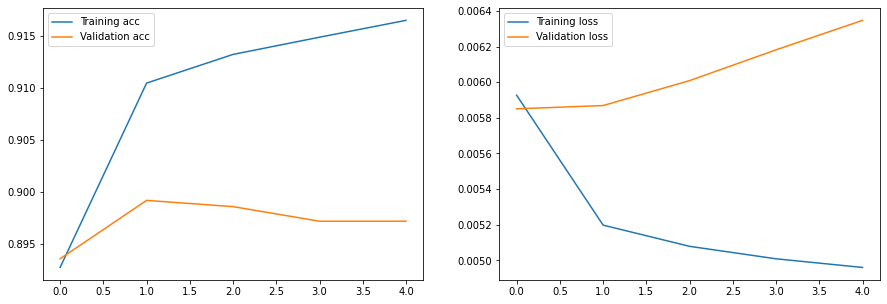

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()

## 네트워크 가중치 시각화
이제 신경망의 가중치를 시각화하고 어떻게 생겼는지 살펴보겠습니다. 네트워크가 하나의 레이어보다 더 복잡한 경우 이와 같은 결과를 시각화하는 것이 어려울 수 있습니다. 그러나 우리의 경우(숫자 분류) 초기 이미지에 가중치 행렬을 곱하는 로직을 추가하여 네트워크 가중치를 시각화할 수 있습니다.

크기가 784x10인 weight_tensor를 생성해 보겠습니다. 이 텐서는 net.parameters() 메서드를 호출하여 얻을 수 있습니다. 이 예에서 숫자가 0인지 확인하려면 입력 자릿수에 weight_tensor[0]을 곱하고 결과를 소프트맥스 정규화를 통해 전달하여 답을 얻습니다. 그 결과 분류하는 숫자의 평균 모양과 다소 유사한 가중치 텐서 요소가 생성됩니다.

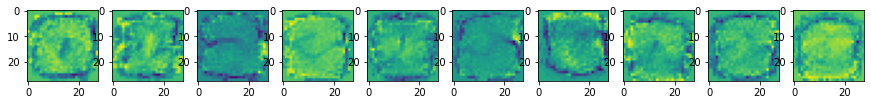

In [28]:
weight_tensor = next(net.parameters())
fig, ax = plt.subplots(1, 10, figsize=(15,4))
for i, x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).detach())

## Taekaway
PyTorch에서 신경망 훈련은 반복문으로 프로그래밍할 수 있습니다. 복잡한 과정처럼 보일 수 있지만 한 번만 작성하면 나중에 이 코드를 변경하지 않고 다시 사용할 수 있습니다.

단일 레이어 뉴럴넷이 상대적으로 좋은 성능을 보여주지만 우리는 정확도 91% 이상의 모델을 원합니다. 다음 단원에서는 다단계 퍼셉트론을 사용할 예정입니다.